#  Irradiation Calcualtions

This details just how much information can be processed with the `COLLISON.txt` file.

In [305]:
%matplotlib inline

import os
from collections import Counter
from itertools import count
from random import randint
from pathlib import Path
import math

# Only needed to embed the images in notebook so they
# show up in gitlab repo
from IPython.display import Image

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.stats import gaussian_kde
import seaborn

from srim import TRIM, Target, Layer, Ion, Element

# directory to srim executable (must be SRIM 2013)
SRIM_EXECUTABLE_DIRECTORY = os.path.abspath('C:/Users/peppe/Desktop/SRIM')
# directory to store srim output (does not have to exist)
DATA_DIRECTORY = os.path.abspath('C:/Users/peppe/Desktop/SRIM_test/')
# directory to store images from processing srim output (does not have to exist)
IMAGE_DIRECTORY = os.path.abspath('C:/Users/peppe/Desktop/Image_test/')

os.makedirs(DATA_DIRECTORY, exist_ok=True)
os.makedirs(IMAGE_DIRECTORY, exist_ok=True)

#Some displacement energies for popular elements
from enum import Enum
class E_d(Enum):
    #Elements
    C = 69
    Si = 37
    Cr = 40
    Mn = 33
    Fe = 40
    Ni = 33
    Mo = 65
    W = 90
    Nb = 78
    V = 57
    #Some more...
    Al = 27
    Mg = 20
    P = 20
    S = 20
    Ti = 30
    Co = 36
    Cu = 30
    Y = 36
    Zr = 40
    N = 28 #not sure, using SRIM default

In [308]:
# Define calculations in code
ions = [
    {'identifier': 'H', 'energy': 2.9e6}, # eV
    #{'identifier': 'C', 'energy': 4.5e6}, # eV
    #{'identifier': 'O', 'energy': 6.5e6}, # eV
    #{'identifier': 'Si', 'energy': 21.0e6}, # eV
    #{'identifier': 'Ni', 'energy': 21.0e6}, # eV
]

width = 40 # um

SS304 = Layer({
        'Fe': {
            'stoich': 66.495,
            'E_d': E_d.Fe.value,
            'lattice': 0,
            'surface': 0
        }
        ,'C': {
            'stoich': 0.08,
            'E_d': E_d.C.value,
            'lattice': 0,
            'surface': 0
        },'Cr': {
            'stoich': 20.0,
            'E_d': E_d.Cr.value,
            'lattice': 0,
            'surface': 0
        }
        ,'Mn': {
            'stoich': 2.0,
            'E_d': E_d.Mn.value,
            'lattice': 0,
            'surface': 0
        }
        ,'Ni': {
            'stoich': 10.5,
            'E_d': E_d.Ni.value,
            'lattice': 0,
            'surface': 0
        }
        ,'Si': {
            'stoich': 0.75,
            'E_d': E_d.Si.value,
            'lattice': 0,
            'surface': 0
        }
        ,'P': {
            'stoich': 0.045,
            'E_d': E_d.P.value,
            'lattice': 0,
            'surface': 0
        },'S': {
            'stoich': 0.03,
            'E_d': E_d.S.value,
            'lattice': 0,
            'surface': 0
        },'N': {
            'stoich': 0.1,
            'E_d': E_d.N.value,
            'lattice': 0,
            'surface': 0
        }
        }, density=8.00, width=width*10000, name='SS304')
target = Target([SS304]) #can add more layers in array form

# number of ions to use in each SRIM calculation
# allows for fragmentation of calcluation
# step size should never be larger than 1,000
# if you are storing COLLISON.txt
IONS_PER_STEP = 999
# number of ions to simulate for each ion
NUM_IONS = 10000

# See TRIMSettings and TRIM for full options
# you can do any setting that you could do in TRIM
TRIM_SETTINGS = {
    'calculation': 2, # full cascade
    'collisions': 2,
    # 'angle_ions': 30
}

In [309]:
# Helper functions to run calculations
def fragment(step, total):
    remaining = total
    while remaining > 0:
        if step > remaining:
            return remaining
        else:
            remaining -= step
            yield step
            
def find_folder(directory):
    for i in count():
        path = Path(directory) / str(i)
        if not path.is_dir():
            return str(path.absolute())

def run_fragmented_calculation(ion, target, number_ions, path, trim_settings, step):
    for i, num_ions in enumerate(fragment(step, number_ions)):
        print('total ions completed: {:06d}\tion: {}\tions in step: {:06d}'.format(i*step, ion.symbol, num_ions))
        trim_settings = trim_settings or {'calculation': 2}
        trim = TRIM(target, ion, number_ions=num_ions, **trim_settings)
        results = trim.run(SRIM_EXECUTABLE_DIRECTORY)
        save_directory = find_folder(path)
        print('calculation saved to:', save_directory)
        os.makedirs(save_directory, exist_ok=True)
        TRIM.copy_output_files(SRIM_EXECUTABLE_DIRECTORY, save_directory)

# Running TRIM in fragments

TRIM has a tendancy to crash so the above wrapper functions run a TRIM calcualtion in `steps` of size 1,000 ions - 10,000 total.

In [310]:
# Run SRIM calcluations for each ion
for ion in ions:
    symbol_path = os.path.join(DATA_DIRECTORY, ion['identifier'])
    run_fragmented_calculation(Ion(**ion), target, NUM_IONS, symbol_path, TRIM_SETTINGS, step=IONS_PER_STEP)

total ions completed: 000000	ion: H	ions in step: 000999
calculation saved to: C:\Users\peppe\Desktop\SRIM_test\H\10
total ions completed: 000999	ion: H	ions in step: 000999
calculation saved to: C:\Users\peppe\Desktop\SRIM_test\H\11
total ions completed: 001998	ion: H	ions in step: 000999
calculation saved to: C:\Users\peppe\Desktop\SRIM_test\H\12
total ions completed: 002997	ion: H	ions in step: 000999
calculation saved to: C:\Users\peppe\Desktop\SRIM_test\H\13
total ions completed: 003996	ion: H	ions in step: 000999
calculation saved to: C:\Users\peppe\Desktop\SRIM_test\H\14
total ions completed: 004995	ion: H	ions in step: 000999
calculation saved to: C:\Users\peppe\Desktop\SRIM_test\H\15
total ions completed: 005994	ion: H	ions in step: 000999
calculation saved to: C:\Users\peppe\Desktop\SRIM_test\H\16
total ions completed: 006993	ion: H	ions in step: 000999
calculation saved to: C:\Users\peppe\Desktop\SRIM_test\H\17
total ions completed: 007992	ion: H	ions in step: 000999
calcula

# Analysis

We are going to plot the collisions from ions and recoil atoms. The COLLISON.txt file can get huge.

 - Read Collisions.txt
 - Plot heatmap of yz plane
 - Radial distribution of yz plane about center (0, 0)

In [257]:
# Helper functions
def parse_directory(dir):
    """ Parse directory with expected structure <dir>/<ion_symbol>/<int>/COLLISON.txt
    
    This functions will collect the position <x, y, z> of every ion and recoil collision.
    
    It will write to a numpy array the parsing. This file will be about 10% of the original
    """
    if not os.path.exists(os.path.join(dir, 'collision.dat.npy')):
        positions = []
        with open(os.path.join(dir, 'COLLISON.txt'), 'rb') as f:
            for line in f.readlines():
                line = line.decode('latin-1')
                if line.endswith('Start of New Cascade  ³\r\n'):
                    tokens = line.split(chr(179))[1:-1]
                    positions.append([float(tokens[2]), float(tokens[3]), float(tokens[4])])
                elif line.startswith('Û 0'):
                    tokens = line.split()[1:-1]
                    positions.append([float(tokens[3]), float(tokens[4]), float(tokens[5])])
        np.save(os.path.join(dir, 'collision.dat'), np.array(positions))

def plot_heatmap(ax, data, cols, limits, norm, bins=(1000, 200)):
    """ Plot a heatmap
    
    Parameters
    ----------
    ax : maptlotlib.axes
        axis to plot heatmap on
    data : np.ndarray
        numpy array that was constructed from 'parse_directory' it is [Nx3] in dimmension.
    cols : tuple
        tuple or list length 2. example (0, 2) x, z axis
    limits : tuple
        tuple or list (2x2) [[col[0] min, col[0] max], [col[0] min, col[0] max]]
    norm : mpl.colors
        colorbar scale to use
    """
    c1, c2 = cols
    (c1min, c1max), (c2min, c2max) = limits
    region_data = data[(data[:, c1] < c1max) & (data[:, c1] > c1min) & (data[:, c2] < c2max) & (data[:, c2] > c2min)]
    heatmap, xedges, yedges = np.histogram2d(region_data[:, c1], region_data[:, c2], range=limits, bins=bins)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    heatmap[heatmap == 0.0] = np.nan
    colormap = mpl.cm.get_cmap('viridis')
    return ax.imshow(heatmap.T, origin='bottom', extent=extent, cmap=colormap, norm=norm)
    
def plot_radial_distribution_hist(ax, data, maximum, label):
    """ plot radial distribution of data
    
    Parameters
    ----------
    ax : maptlotlib.axes
        axis to plot heatmap on
    data : np.ndarray
        numpy array that was constructed from 'parse_directory' it is [Nx3] in dimmension.
    maximum : float
        maximum distance to plot radial distribution
    label : str
        label to give for plot
    """
    density, edges = np.histogram(data, bins=100, density=False, range=(1e-8, maximum))
    x = np.linspace(1e-1, maximum, len(density))
    density = [d / (2 * math.pi * r)  for r, d in zip(x, density)]
    # return ax.plot(x, density, label=label)
    return ax.semilogy(x, density, label=label)
    
def plot_radial_distribution_kde(ax, data, maximum, label):
    """ Same as plot radial distribution of data except uses kde for smoothing"""
    x = np.linspace(0, maximum, 100)
    kde = gaussian_kde(np.concatenate((-data, data)))
    return ax.plot(x, kde.pdf(x), label=label)
    
sort_by_mass = lambda e1: Element(e1).mass

Read all SRIM Calculations and parse COLLISON.txt to produce numpy arrary this will traverse directory structure and create numpy data arrays in each folder

In [275]:
for dir in os.listdir(DATA_DIRECTORY):
    calculation_data = []
    total_ions = 0
    abs_dir_path = os.path.join(DATA_DIRECTORY, dir)
    if os.path.isdir(abs_dir_path):
        for calculation in os.listdir(abs_dir_path):
            if set(calculation) < set('0123456789') and os.path.isdir(os.path.join(abs_dir_path, calculation)): # check that dir only contains numbers
                parse_directory(os.path.join(abs_dir_path, calculation))
                print('parsed', os.path.join(abs_dir_path, calculation))

parsed C:\Users\peppe\Desktop\SRIM_test\H\0
parsed C:\Users\peppe\Desktop\SRIM_test\H\1
parsed C:\Users\peppe\Desktop\SRIM_test\H\2
parsed C:\Users\peppe\Desktop\SRIM_test\H\3
parsed C:\Users\peppe\Desktop\SRIM_test\H\4
parsed C:\Users\peppe\Desktop\SRIM_test\H\5
parsed C:\Users\peppe\Desktop\SRIM_test\H\6
parsed C:\Users\peppe\Desktop\SRIM_test\H\7
parsed C:\Users\peppe\Desktop\SRIM_test\H\8
parsed C:\Users\peppe\Desktop\SRIM_test\H\9


Combine all numpy array read from COLLISON.txt. This will take ALOT of RAM if NUM_IONS > 10,000 (4-6 Gb for me)

In [276]:
data = {}
for dir in os.listdir(DATA_DIRECTORY):
    collisions = []
    total_ions = 0
    if os.path.isdir(os.path.join(DATA_DIRECTORY, dir)):
        for calculation in os.listdir(os.path.join(DATA_DIRECTORY, dir)):
            with open(os.path.join(DATA_DIRECTORY, dir, calculation, 'TRIM.IN')) as f:
                num_ions = int(f.read().split('\n')[2].split()[-3])
            total_ions += num_ions
            collisions.append(np.load(os.path.join(DATA_DIRECTORY, dir, calculation, 'collision.dat.npy')))
        data[dir] = {'total_ions': total_ions, 'collisions': np.concatenate(collisions) / 10}

Print summary information about calculations and collisions

In [277]:
# print summary information
for ion in sorted(data, key=sort_by_mass):
    data_str = (
        "Symbol: {:2}\tNum Ions: {:7d}\tCollisions: {:7d}\n"
        "|\tMedian (x, y, z) [nm]: [{:.3f}\t{:.3f}\t{:.3f}]\n"
        "|\tMean   (x, y, z) [nm]: [{:.3f}\t{:.3f}\t{:.3f}]\n"
    )
    print(data_str.format(ion, data[ion]['total_ions'], len(data[ion]['collisions']), 
                          *np.median(data[ion]['collisions'], axis=0),
                          *np.mean(data[ion]['collisions'], axis=0)))

Symbol: H 	Num Ions:    9990	Collisions:  437626
|	Median (x, y, z) [nm]: [30060.000	2.348	10.650]
|	Mean   (x, y, z) [nm]: [25365.579	-13.062	36.798]



## Image from full 10,000 ion calculation.

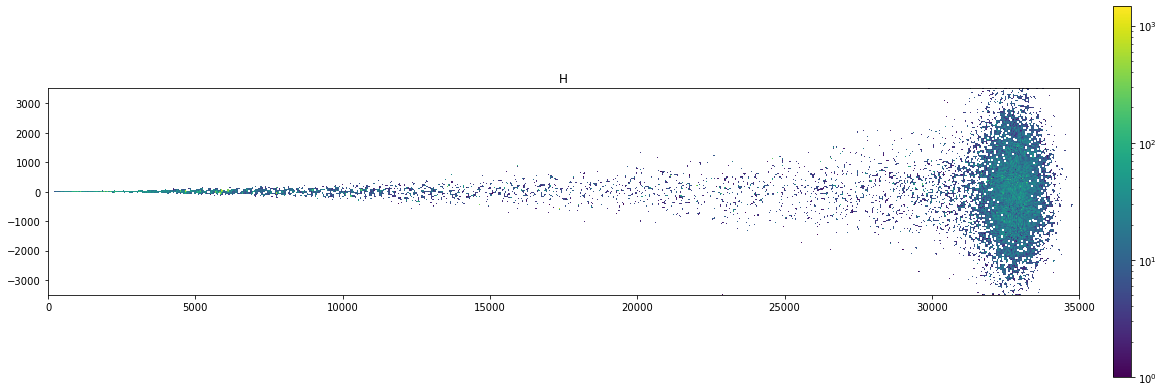

In [280]:
# Using Log color scale
multi = 35
limits = [[0, 1000*multi], [-100*multi, 100*multi]]
bins = (1000, 200)

fig, axes = plt.subplots(2, len(ions))
for ax, ion in zip(axes.flat, sorted(data, key=sort_by_mass)):
    norm = mpl.colors.LogNorm()
    im = plot_heatmap(ax, data[ion]['collisions'], (0, 2), limits, norm, bins=bins)
    ax.set_title(ion)
fig.delaxes(axes[1])

fig.colorbar(im,fraction=0.046, pad=0.03)
#fig.colorbar(im, ax=axes.ravel().tolist())
fig.set_size_inches(20, 15)
fig.savefig(os.path.join(IMAGE_DIRECTORY, 'length-heatmap-log.png'), transparent=False, dpi=300, bbox_inches='tight')

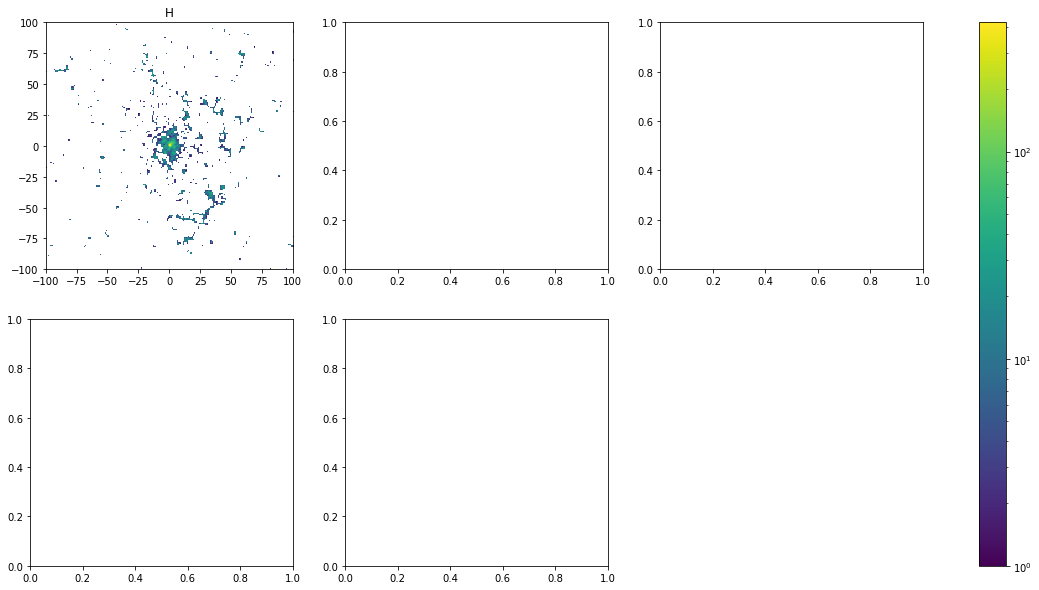

In [281]:
# Using Log color scale
limits = [[-100, 100], [-100, 100]]
bins = (200, 200)

fig, axes = plt.subplots(2, 3)
for ax, ion in zip(axes.flat, sorted(data, key=sort_by_mass)):
    norm = mpl.colors.LogNorm()
    im = plot_heatmap(ax, data[ion]['collisions'], (1, 2), limits, norm, bins=bins)
    ax.set_title(ion)
fig.delaxes(axes[1][2])
fig.colorbar(im, ax=axes.ravel().tolist())
fig.set_size_inches(20, 10)
fig.savefig(os.path.join(IMAGE_DIRECTORY, 'sic-radial-heatmap-log.png'), transparent=False, dpi=300)

Image from full 10,000 ion calculation.

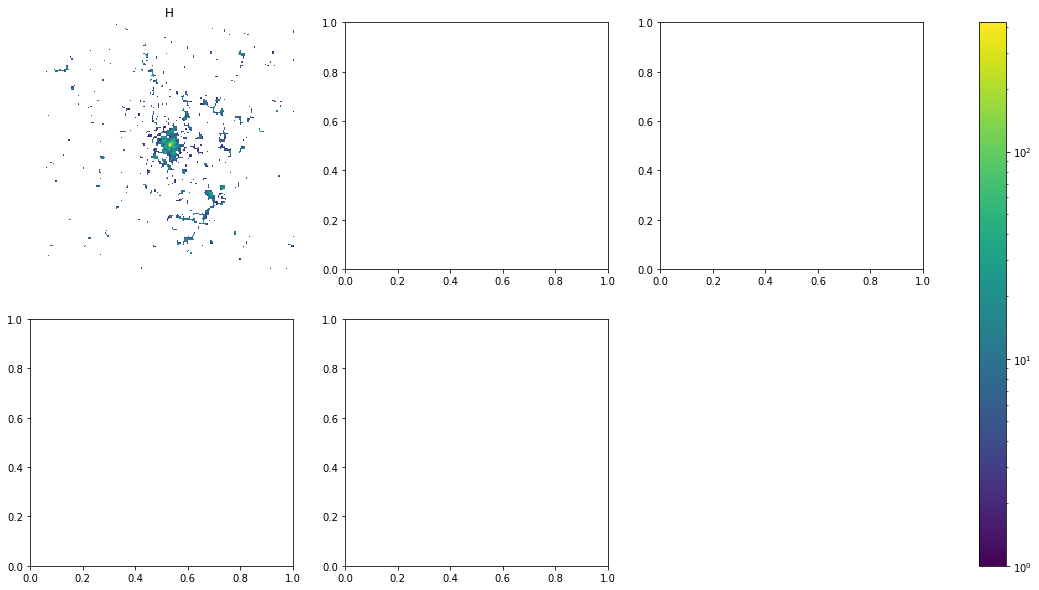

In [304]:
# Using Log color scale
limits = [[-100, 100], [-100, 100]]
bins = (200, 200)

fig, axes = plt.subplots(2, 3)
for ax, ion in zip(axes.flat, sorted(data, key=sort_by_mass)):
    norm = mpl.colors.LogNorm()
    im = plot_heatmap(ax, data[ion]['collisions'], (1, 2), limits, norm, bins=bins)
    ax.set_title(ion)
    ax.axis('off')
fig.delaxes(axes[1][2])
fig.colorbar(im, ax=axes.ravel().tolist())
fig.set_size_inches(20, 10)
fig.savefig(os.path.join(IMAGE_DIRECTORY, 'sic-radial-heatmap-log-nolabel.png'), transparent=False, dpi=300)

# Image from full 10,000 ion calculation.

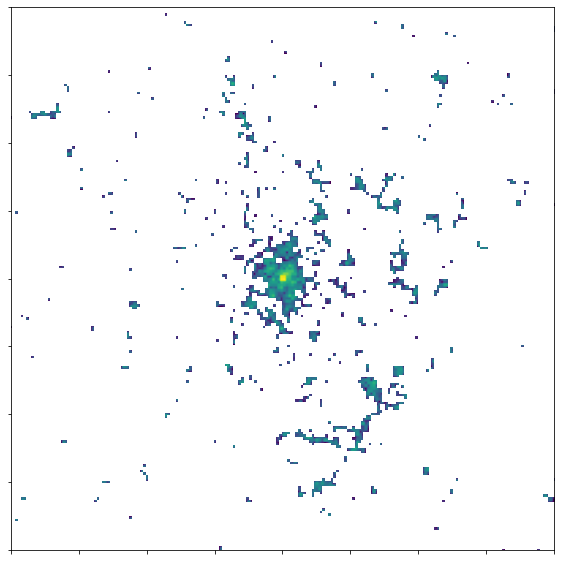

In [286]:
# Using Log color scale - several images
limits = [[-100, 100], [-100, 100]]
bins = (200, 200)

for ion in sorted(data, key=sort_by_mass):
    fig, ax = plt.subplots()
    norm = mpl.colors.LogNorm()
    im = plot_heatmap(ax, data[ion]['collisions'], (1, 2), limits, norm, bins=bins)
    # ax.set_title(ion)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    fig.set_size_inches(10, 10)
    fig.savefig(os.path.join(IMAGE_DIRECTORY, 'sic-radial-heatmap-log-nolabel-%s.png' % ion), transparent=False, dpi=300)

Image from full 10,000 ion calculation.

0 H


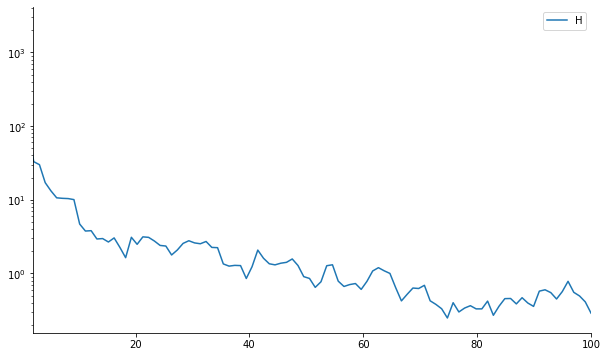

In [250]:
# Very small 100 nm (to more clearly show trend)
maximum = 100

fig, ax = plt.subplots()
for i, ion in enumerate(sorted(data, key=sort_by_mass)):
    print(i, ion)
    radius = np.linalg.norm(data[ion]['collisions'][:, 1:], axis=1)
    plot_radial_distribution_hist(ax, radius, maximum, ion)
# ax.set_title('Histogram Radial Distribution (yz) - %.2f [nm]' % maximum)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlim(2, maximum)
# ax.set_ylim(0, 60000)
ax.legend()
fig.set_size_inches(10, 6)
fig.savefig(os.path.join(IMAGE_DIRECTORY, 'sic-radial-hist.png'), transparent=False, dpi=300)

Image from full 10,000 ion calculation.

Was improperly normalized so image is incorrect.

In [97]:
maximum = 100

for i, ion in enumerate(sorted(data, key=sort_by_mass)):
    print(i, ion)
    radius = np.linalg.norm(data[ion]['collisions'][:, 1:], axis=1)
    density, edges = np.histogram(radius, bins=1000, density=False, range=(1e-8, maximum))
    x = np.linspace(1e-8, maximum, len(density))
    with open(os.path.join(IMAGE_DIRECTORY, 'sic-collisions-%s.csv' % ion), 'w') as f:
        f.write('%s radial distance [nm], count [collisions/A^2]\n' % ion)
        for x,y in zip(x, density):
            f.write('{:3.2f},{}\n'.format(x, y))

0 H
